In [1]:
###____________________TASK1____________________###

import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import matplotlib as pl2
import os
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, GaussianNoise, LeakyReLU
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv2D,Conv1D, MaxPooling2D,MaxPooling1D, Flatten, BatchNormalization, RepeatVector
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import collections
import seaborn as sn
import pandas as pd
import imutils
import cv2
from keras.optimizers import RMSprop
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading in the data, x for features that are being analyzed , and y for the labels, in this case 1-26 (for each letter 1 label).
path_trainingset = "/content/drive/My Drive/Colab Notebooks/training-dataset.npz" #PATH TO TRAININGSET
path_testset = "/content/drive/My Drive/Colab Notebooks/test-dataset.npy" #PAT TO TESTSET



with np.load(path_trainingset) as data:
    img = data["x"]
    lbl = data ["y"]


captcha = np.load(path_testset)


# Only making a training set, as we can specifiy in our model to make a validation set itself. This way we dont have to make any validation set, and the model will
# report performance on both the training set and the validation set.
X_train = img[:124800,:]
y_train = lbl[:124800]

# Normalizing the features so that we get better results when training the model. (for images this mostly is just deviding all numbers by 255.)
X_train = X_train/255

In [5]:
# Train test split with stratification to make sure output classes (labels) are equally distributed in test and valid set

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                    stratify=y_train, 
                                                    test_size=0.2)

In [6]:
# Make the train and validation data 2d (28 x 28) for 2D CNN layers
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_valid_cnn = X_valid.reshape(-1, 28, 28, 1)

In [7]:
# Check if shapes are okay
print(X_train.shape) ##--> FOR MLP
print(X_valid.shape) ## --> FOR MLP
print(X_train_cnn.shape) ## --> FOR CNN
print(X_valid_cnn.shape) ## --> FOR CNN

(99840, 784)
(24960, 784)
(99840, 28, 28, 1)
(24960, 28, 28, 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                13851     
Total params: 678,427
Trainable params: 678,427
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
780/780 [==============================] - 10s 12ms/step - loss: 1.0860 - accuracy: 0.6770 - val_loss: 0.

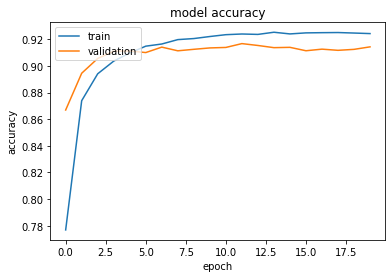

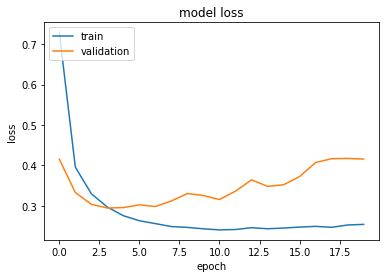

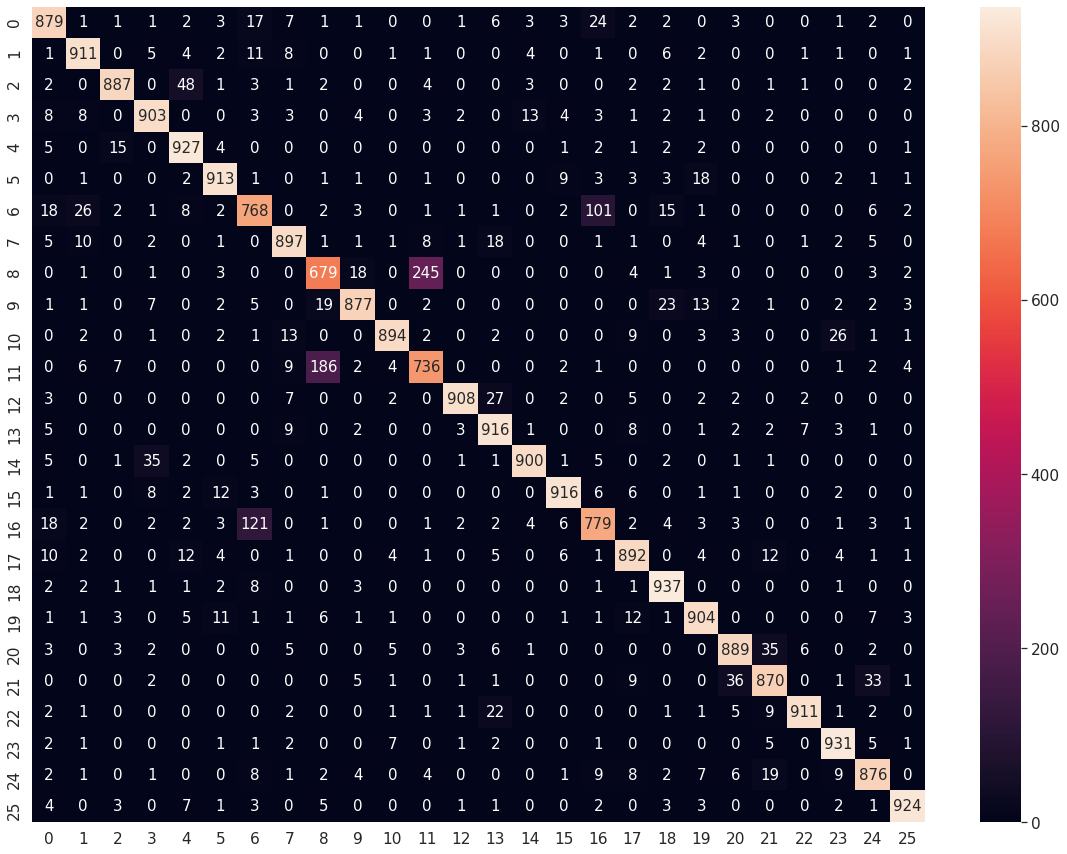

In [8]:
##Keras MNIST MLP (Multilayer Perceptron)
## 3 Dense Layers: dimensionality of output shape: 512-512-26
## Drop-out rate of 0.2


#### The MLP Model ####
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))

model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(27, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size=128, epochs = 20, validation_data = (X_valid, y_valid))

#### Summarize history accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

### Summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

### Create confusion matrix
y_pred  = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred.argmax(axis=1))
df_cm = pd.DataFrame(cm, range(26), range(26))
plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt = 'g') # font size

plt.show()

Epoch 1/20
780/780 [==============================] - 66s 84ms/step - loss: 1.4240 - accuracy: 0.5791 - val_loss: 0.3571 - val_accuracy: 0.8843
Epoch 2/20
780/780 [==============================] - 66s 84ms/step - loss: 0.4614 - accuracy: 0.8545 - val_loss: 0.2715 - val_accuracy: 0.9120
Epoch 3/20
780/780 [==============================] - 66s 84ms/step - loss: 0.3702 - accuracy: 0.8802 - val_loss: 0.2467 - val_accuracy: 0.9204
Epoch 4/20
780/780 [==============================] - 66s 84ms/step - loss: 0.3183 - accuracy: 0.8967 - val_loss: 0.2246 - val_accuracy: 0.9266
Epoch 5/20
780/780 [==============================] - 65s 84ms/step - loss: 0.2894 - accuracy: 0.9069 - val_loss: 0.2085 - val_accuracy: 0.9318
Epoch 6/20
780/780 [==============================] - 66s 84ms/step - loss: 0.2668 - accuracy: 0.9123 - val_loss: 0.2054 - val_accuracy: 0.9327
Epoch 7/20
780/780 [==============================] - 65s 84ms/step - loss: 0.2526 - accuracy: 0.9157 - val_loss: 0.2006 - val_accuracy:

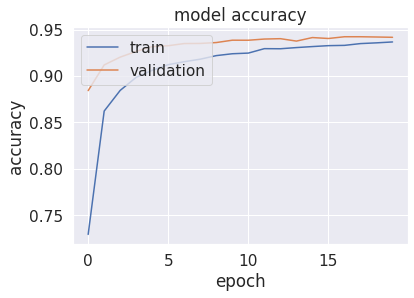

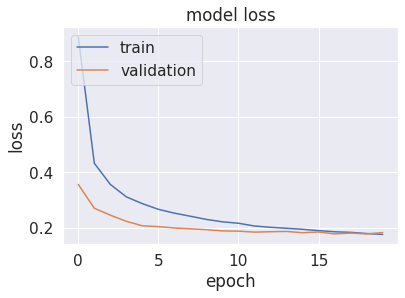

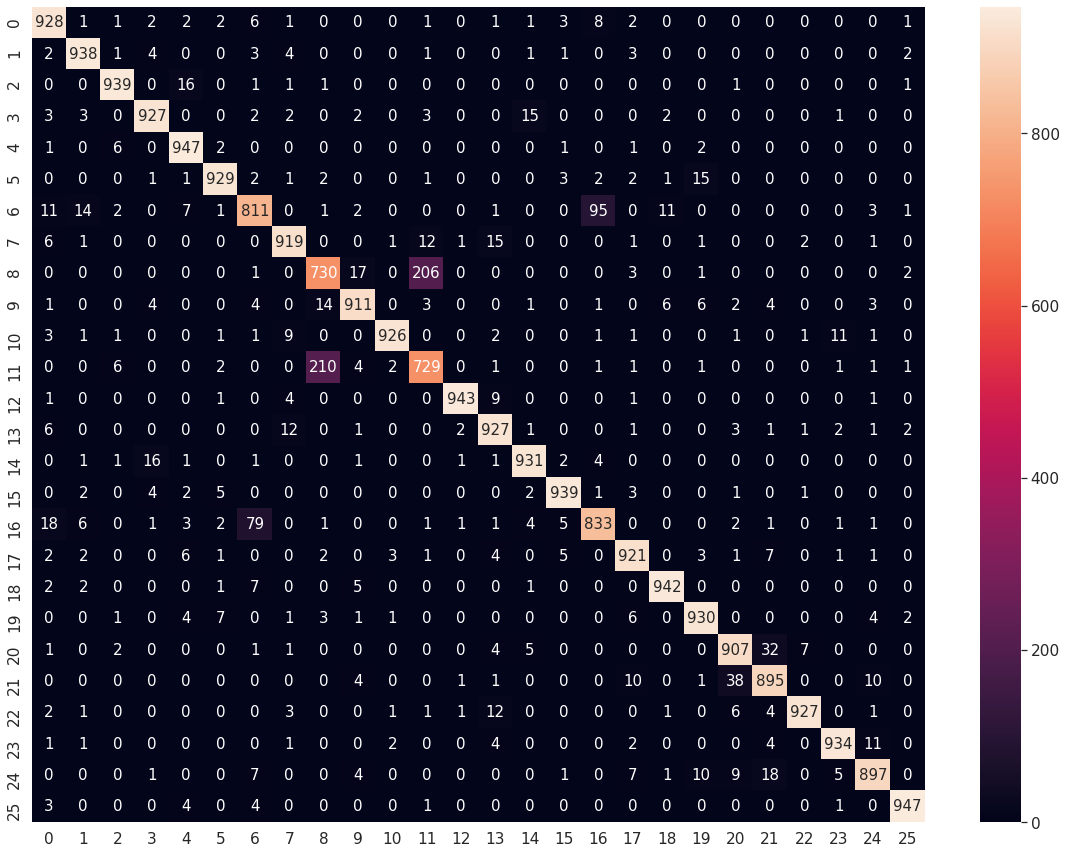

In [9]:
# Final CNN!!!
# 2 Convonutional2D layers, Filters: 32 - 64, Kernel size (4,4) - (3,3)
# Pooling (2,2)
# Dropoutrate of 0,2
# Dense layers: dimensionality of outputshape 64-26
opt = tf.optimizers.Adam(learning_rate=0.001)

#### The CNN Model ####
model = Sequential()

model.add(Conv2D(32, (4,4), input_shape = (28,28,1), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(GaussianNoise(0.025))
model.add(Dense(64, activation = 'relu'))

model.add(Dropout(0.2))

model.add(Dense(27, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ["accuracy"])

history = model.fit(X_train_cnn, y_train, batch_size=128, epochs = 20 , validation_data = (X_valid_cnn, y_valid))

#### Summarize history accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

### Summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

### Create confusion matrix
y_pred  = model.predict(X_valid_cnn)
cm = confusion_matrix(y_valid, y_pred.argmax(axis=1))
df_cm = pd.DataFrame(cm, range(26), range(26))
plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt = 'g') # font size

plt.show()

In [10]:
###____________________TASK2____________________###
# code from Git-Hub -> https://gist.github.com/Prasad9/077050d9a63df17cb1eaf33df4158b19
# Add noise to the training set so that the CNN can learn to recognize letters within noisy images. 
# After adding noise , we train the model again with this new training dataset.
def add_salt_pepper_noise(X_imgs):
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.5
    amount = 0.02
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
      coords = [np.random.randint(0, i , int(num_salt)) for i in X_img.shape]
      X_img[coords[0], coords[1], :] = 1


      coords = [np.random.randint(0, i , int(num_pepper)) for i in X_img.shape]
      X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy


In [11]:
# After running this cell, rerun the CNN
X_train_cnn = add_salt_pepper_noise(X_train_cnn)
X_valid_cnn = add_salt_pepper_noise(X_valid_cnn)

In [12]:
img1 = captcha[0]
# Splitting data up into 5 equal "windows"
listt = []
for a in range(captcha.shape[0]):
    b = captcha[a,:,1:29]
    c = captcha[a,:,29:57]
    d = captcha[a,:,57:85]
    e = captcha[a,:,85:113]
    f = captcha[a,:,113:141]
    listt.append((b,c,d,e,f))
array = np.asarray(listt)
print(array.shape)

list2 = []
for complete_image in array:
	for one_image in complete_image:
		one_image = one_image[1:29,:]
		list2.append(one_image)


(10000, 5, 30, 28)


In [13]:
# Reshape the different windows so that the inputsize matches with the expected inputsize of the CNN
final_set = np.asarray(list2)
final_set = final_set.reshape((-1, 28,28,1))
final_set = final_set/255



In [14]:
# Predicting 
lbl_pred1 = model.predict(final_set)

In [15]:
# Configuring the predictions in the right format for the project.
predictions =[ [] for i in range(250000)]
for i in range(len(lbl_pred1)):
  top5= sorted( [(x,i) for (i,x) in enumerate(lbl_pred1[i])], reverse=True )[:5]
  predictions[i].append(top5[0][1]) 
  predictions[i+50000].append(top5[1][1]) 
  predictions[i+100000].append(top5[2][1]) 
  predictions[i+150000].append(top5[3][1]) 
  predictions[i+200000].append(top5[4][1]) 

prediction1 = ""
for i in range(0,250000,5):
  if predictions[i+0][0] <=9:
      prediction1 += "0" + (str(predictions[i][0]))
  else:
    prediction1 += str(predictions[i][0])
  if predictions[i+1][0] <=9:
      prediction1 += "0" + (str(predictions[i+1][0]))
  else:
    prediction1 += str(predictions[i+1][0])
  if predictions[i+2][0] <=9:
      prediction1 += "0" + (str(predictions[i+2][0]))
  else:
    prediction1 += str(predictions[i+2][0])
  if predictions[i+3][0] <=9:
      prediction1 += "0" + (str(predictions[i+3][0]))
  else:
    prediction1 += str(predictions[i+3][0])
  if predictions[i+4][0] <=9:
      prediction1 += "0" + (str(predictions[i+4][0]))
  else:
    prediction1 += str(predictions[i+4][0])
  prediction1 += ","
prediction1 = prediction1.replace("[","").replace("]","")
prediction1 = prediction1.split(',')

In [16]:
pred1= prediction1[0:9999]
pred2= prediction1[10000:19999]
pred3= prediction1[20000:29999]
pred4= prediction1[30000:39999]
pred5= prediction1[40000:49999]
indexrow = np.array(range(0,9999))
data =np.row_stack((pred1, pred2,pred3,pred4,pred5))
dataf = pd.DataFrame(data)
dataf_t = dataf.T
dataf_t.to_csv("group-52-predictions.csv",index=False,header=False,index_label=False)
